In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(p1_probs, p2_probs, p3_probs):
    """
    使用散点图+小提琴图展示概率分布
    
    Args:
        p1_probs: TIS非0概率值列表
        p2_probs: TTS非0概率值列表
        p3_probs: Non-TIS/TTS非1概率值列表
    """
    plt.figure(figsize=(12, 6))
    
    # 准备数据
    data = [p1_probs, p2_probs, p3_probs]
    positions = [1, 2, 3]
    colors = ['red', 'blue', 'gray']
    labels = ['TIS\nnon-zero', 'TTS\nnon-zero', 'Non-TIS/TTS\nnon-one']
    
    # 绘制小提琴图
    parts = plt.violinplot(data, positions, points=100, showmeans=True, 
                          showextrema=True, showmedians=True)
    
    # 设置小提琴图的颜色
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.3)
    
    # 设置其他小提琴图元素的颜色
    parts['cmeans'].set_color('black')
    parts['cmedians'].set_color('black')
    parts['cbars'].set_color('black')
    parts['cmins'].set_color('black')
    parts['cmaxes'].set_color('black')
    
    # 添加散点图（使用抖动效果避免重叠）
    for i, (d, pos, color) in enumerate(zip(data, positions, colors)):
        # 为散点添加随机抖动
        x = np.random.normal(pos, 0.04, size=len(d))
        plt.scatter(x, d, c=color, alpha=0.2, s=5)
    
    # 设置图表样式
    plt.title('Distribution of Non-zero/Non-one Probabilities')
    plt.ylabel('Probability')
    plt.grid(True, axis='y', alpha=0.3)
    plt.xticks(positions, labels)
    
    # 添加统计信息
    stats_text = (
        f"Statistics (mean ± std):\n"
        f"TIS: {np.mean(p1_probs):.4f} ± {np.std(p1_probs):.4f} (n={len(p1_probs)})\n"
        f"TTS: {np.mean(p2_probs):.4f} ± {np.std(p2_probs):.4f} (n={len(p2_probs)})\n"
        f"Non-TIS/TTS: {np.mean(p3_probs):.4f} ± {np.std(p3_probs):.4f} (n={len(p3_probs)})"
    )
    plt.figtext(0.15, 0.02, stats_text, fontsize=8)
    
    # 调整布局
    plt.subplots_adjust(bottom=0.2)
    plt.show()

def analyze_transcript_probabilities(pkl_file, target_id=None, num_transcripts=None, plot_type='both'):
    """
    Analyze and visualize prediction probabilities for transcripts.
    
    Args:
        pkl_file (str): Path to the pickle file containing predictions
        target_id (str, optional): Target transcript ID to analyze. Defaults to None.
        num_transcripts (int, optional): Number of transcripts to analyze when target_id is None.
        plot_type (str): Type of plot to generate ('prob', 'box', or 'both'). Defaults to 'both'.
    """
    # 验证输入参数
    if plot_type not in ['prob', 'box', 'both']:
        raise ValueError("plot_type must be 'prob', 'box', or 'both'")
        
    # 读取预测结果
    with open(pkl_file, 'rb') as f:
        predictions = pickle.load(f)
    #print(predictions)
    # 创建列表来存储概率值
    p1_probs = []  # TIS非0概率值
    p2_probs = []  # TTS非0概率值
    p3_probs = []  # Non-TIS/TTS非1概率值
    
    n = 0
    found_target = False
    
    for item in predictions:
        # 如果指定了target_id，只处理目标转录本
        if target_id is not None:
            print(item['transcript_id'])
            if item['transcript_id'] == target_id:
                found_target = True
                for i,probs in enumerate(item['predictions_probs']):
                    if probs[2] <0.95:
                        print(i,probs)
            else:
                continue
                
        # 获取概率数据
        probs_array = np.array(item['predictions_probs'])
        positions = np.arange(len(probs_array))
        
        # 收集概率值
        p1_probs.extend(probs_array[:, 0][probs_array[:, 0] > 0.01])
        p2_probs.extend(probs_array[:, 1][probs_array[:, 1] > 0.01])
        p3_probs.extend(probs_array[:, 2][probs_array[:, 2] < 0.99])
        
        # 绘制概率图
        if plot_type in ['prob', 'both']:
            plt.figure(figsize=(15, 6))
            plt.scatter(positions, probs_array[:, 0], color='red', s=2, alpha=0.7, label='TIS')
            plt.scatter(positions, probs_array[:, 1], color='blue', s=2, alpha=0.7, label='TTS')
            plt.scatter(positions, probs_array[:, 2], color='gray', s=2, alpha=0.7, label='Non-TIS/TTS')
            
            plt.title(f'Prediction Probabilities for {item["transcript_id"]}')
            plt.xlabel('Sequence Position')
            plt.ylabel('Probability')
            plt.legend()
            plt.ylim(-0.05, 1.05)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # 计数器增加
        n += 1
        
        # 检查是否达到目标数量
        if target_id is None and num_transcripts is not None and n >= num_transcripts:
            break
            
        # 如果找到了目标转录本，退出循环
        if target_id is not None and found_target:
            break
    
    # 如果指定了target_id但未找到，提示错误
    if target_id is not None and not found_target:
        print(f"Transcript {target_id} not found in predictions")
        return
    
    # 绘制箱线图
    if plot_type in ['box', 'both']:
        plot_distribution(p1_probs, p2_probs, p3_probs)


In [2]:
# 使用示例
pkl_NR_match = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NR_matching_predictions.pkl"
pkl_NR_nonMatch = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NR_non_matching_predictions.pkl"
pkl_NM_match = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NM_matching_predictions.pkl"
pkl_NM_nonMatch = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NM_non_matching_predictions.pkl"
pkDEL3_NM_Match = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NMNR_CDS_3DEL/TRANSAID_Embedding_batch4_NM_CDS_3DEL_matching_predictions.pkl"
pkDEL3_NM_nonMatch = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NMNR_CDS_3DEL/TRANSAID_Embedding_batch4_NM_CDS_3DEL_non_matching_predictions.pkl"
pkCDSshuffle_NM_nonMatch = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NMNR_CDS_shuffle_tmp/TRANSAID_Embedding_batch4_NM_CDS_shuffle_predictions.pkl"

pkl_v2_NR_match = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_v2_batch4_NR_matching_predictions.pkl"
pkl_v2_NR_nonMatch = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_v2_batch4_NR_non_matching_predictions.pkl"
pkl_v2_NM_match = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_v2_batch4_NM_matching_predictions.pkl"
pkl_v2_NM_nonMatch = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_v2_batch4_NM_non_matching_predictions.pkl"
pkl_test = "/home/jovyan/work/insilico_translation/transaid/test_data/GRCh38_test.pkl"
# 示例1：分析单个转录本，显示所有图
#analyze_transcript_probabilities(pkl_file, target_id="NR_182758", plot_type='both')
# 示例2：分析前50个转录本，只显示概率图
#analyze_transcript_probabilities(pkl_file, target_id=None, num_transcripts=50, plot_type='prob')

# 示例3：分析前100个转录本，只显示箱线图
'''
analyze_transcript_probabilities(pkl_NR_match, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_NR_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_NM_match, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_NM_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_v2_NR_match, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_v2_NR_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_v2_NM_match, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_v2_NM_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')
'''

"\nanalyze_transcript_probabilities(pkl_NR_match, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_NR_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_NM_match, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_NM_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_v2_NR_match, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_v2_NR_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_v2_NM_match, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_v2_NM_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')\n"

NM_000014.6
70 [9.6682972e-01 3.5915382e-05 3.3134304e-02]
71 [9.728075e-01 5.273409e-05 2.713964e-02]
72 [9.7008026e-01 2.8334111e-05 2.9891370e-02]
4492 [5.0999450e-05 9.8738664e-01 1.2562308e-02]
4493 [2.1435861e-05 9.8965502e-01 1.0323565e-02]
4494 [4.1817137e-05 9.8137164e-01 1.8586561e-02]


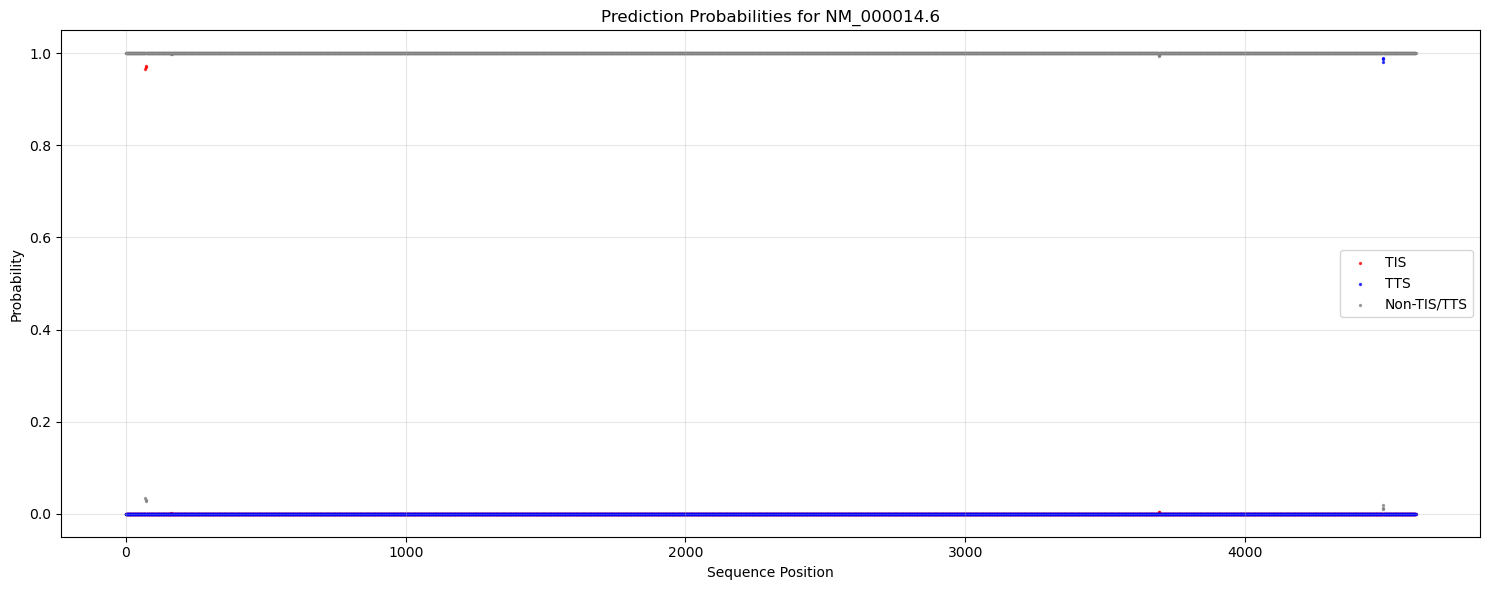

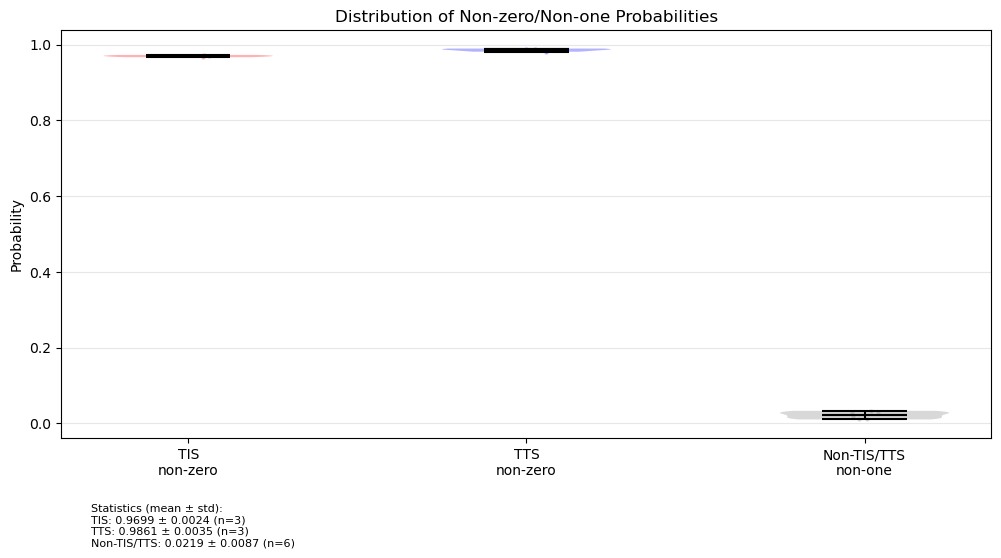

In [10]:

# 示例1：分析单个转录本，显示所有图
#analyze_transcript_probabilities(pkl_NM_nonMatch, target_id="NR_160788", plot_type='both')
#analyze_transcript_probabilities(pkDEL3_NM_nonMatch, target_id="NM_000448", plot_type='both')
#analyze_transcript_probabilities(pkl_NM_match, target_id="NM_000016", plot_type='both')
analyze_transcript_probabilities(pkl_test, target_id="NM_000014.6", plot_type='both')

In [4]:
from Bio import SeqIO
from collections import defaultdict
import re

def find_non_aug_transcripts(gbff_file):
    """
    Parse GRCh38 RNA gbff file to find transcripts with non-AUG start codons.
    
    Args:
        gbff_file (str): Path to the gbff file
    
    Returns:
        list: List of dictionaries containing information about non-AUG transcripts
    """
    non_aug_transcripts = []
    codon_counts = defaultdict(int)
    
    # Parse GenBank file
    for record in SeqIO.parse(gbff_file, "genbank"):
        transcript_id = record.id
        
        for feature in record.features:
            if feature.type == "CDS":
                # Get coding sequence location
                if isinstance(feature.location, str):
                    continue
                    
                start_pos = int(feature.location.start)
                end_pos = int(feature.location.end)
                
                # Extract the start codon
                start_codon = str(record.seq[start_pos:start_pos+3]).upper()
                
                # Check if it's a non-AUG start codon
                if start_codon != "ATG":
                    # Collect relevant information
                    info = {
                        "transcript_id": transcript_id,
                        "start_codon": start_codon,
                        "position": start_pos + 1,  # 1-based position
                        "gene_name": feature.qualifiers.get("gene", ["Unknown"])[0],
                        "protein_id": feature.qualifiers.get("protein_id", ["Unknown"])[0]
                    }
                    
                    # Get product information if available
                    if "product" in feature.qualifiers:
                        info["product"] = feature.qualifiers["product"][0]
                    
                    non_aug_transcripts.append(info)
                    codon_counts[start_codon] += 1
    
    return non_aug_transcripts, codon_counts

def write_results(transcripts, counts, output_file):
    """
    Write results to a tab-delimited file.
    """
    with open(output_file, 'w') as f:
        # Write header
        f.write("Transcript_ID\tGene_Name\tStart_Codon\tPosition\tProtein_ID\tProduct\n")
        
        # Write transcript information
        for t in transcripts:
            product = t.get("product", "Unknown")
            f.write(f"{t['transcript_id']}\t{t['gene_name']}\t{t['start_codon']}\t"
                   f"{t['position']}\t{t['protein_id']}\t{product}\n")
        
        # Write summary statistics
        f.write("\n\nStart Codon Usage Summary:\n")
        for codon, count in sorted(counts.items(), key=lambda x: x[1], reverse=True):
            f.write(f"{codon}: {count}\n")

def main():
    # File paths
    input_file = "/home/jovyan/work/insilico_translation/dataset/GRCh38_latest_rna.gbff"
    output_file = "/home/jovyan/work/insilico_translation/dataset/non_aug_transcripts.txt"
    
    print("Analyzing transcripts for non-AUG start codons...")
    non_aug_transcripts, codon_counts = find_non_aug_transcripts(input_file)
    
    print(f"Found {len(non_aug_transcripts)} transcripts with non-AUG start codons")
    print("\nStart codon distribution:")
    for codon, count in sorted(codon_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{codon}: {count}")
    
    write_results(non_aug_transcripts, codon_counts, output_file)
    print(f"\nResults have been written to {output_file}")

if __name__ == "__main__":
    main()

Analyzing transcripts for non-AUG start codons...
Found 112 transcripts with non-AUG start codons

Start codon distribution:
CTG: 67
GTG: 10
ATA: 6
TTG: 5
CCA: 5
ATT: 4
ACG: 3
CCC: 3
TGG: 1
TGC: 1
AAC: 1
GCC: 1
TAT: 1
TTT: 1
AGA: 1
ACT: 1
CTT: 1

Results have been written to /home/jovyan/work/insilico_translation/dataset/non_aug_transcripts.txt



Test values:
GC content: 0.41 -> Score: 0.990
GC content: 0.35 -> Score: 0.846
GC content: 0.45 -> Score: 0.990
GC content: 0.30 -> Score: 0.619
GC content: 0.50 -> Score: 0.881


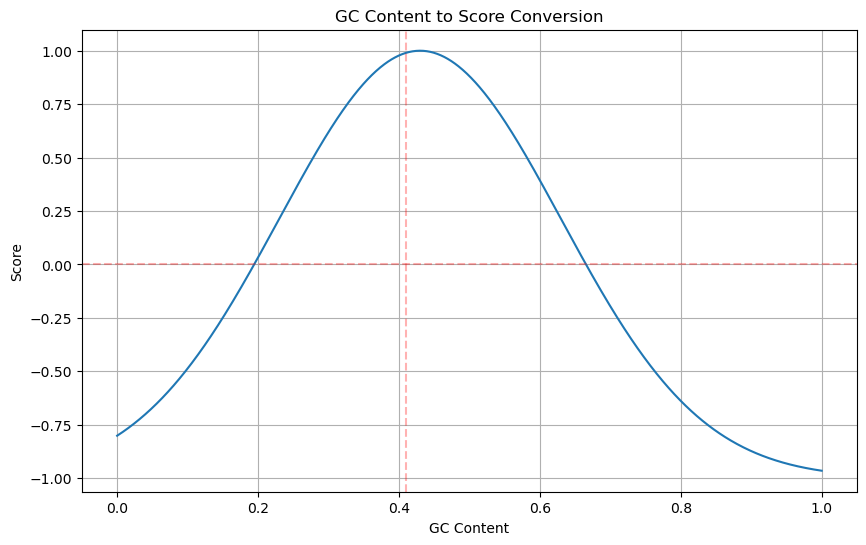

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def gc_to_score(gc_content, mean_gc=0.43, std_gc=0.2):
    """
    将GC含量转换为-1到1之间的得分
    
    参数:
    gc_content: float or numpy array, GC含量值
    mean_gc: float, GC含量的期望值（默认0.41）
    std_gc: float, GC含量的标准差（可调整，控制曲线陡峭程度）
    
    返回:
    float or numpy array: 转换后的得分
    """
    # 使用高斯函数变换
    score = 2 * np.exp(-0.5 * ((gc_content - mean_gc) / std_gc) ** 2) - 1
    return score

# 测试和可视化
if __name__ == "__main__":
    # 生成测试数据
    gc_values = np.linspace(0, 1, 1000)
    scores = gc_to_score(gc_values)
    
    # 绘制转换曲线
    plt.figure(figsize=(10, 6))
    plt.plot(gc_values, scores)
    plt.grid(True)
    plt.xlabel('GC Content')
    plt.ylabel('Score')
    plt.title('GC Content to Score Conversion')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.axvline(x=0.41, color='r', linestyle='--', alpha=0.3)
    
    # 测试一些具体值
    test_values = [0.41, 0.35, 0.45, 0.3, 0.5]
    print("\nTest values:")
    for gc in test_values:
        score = gc_to_score(gc)
        print(f"GC content: {gc:.2f} -> Score: {score:.3f}")
    
    plt.show()

In [6]:
import torch
import os

check_dir = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NMNR_CDS_3DEL/validation_check"  # 替换成实际保存路径，例如 "./saved_data"
seq_id = "NM_000448"         # 替换成具体序列ID，例如 "seq_001"

# 读取编码数据
encoded_data = torch.load(os.path.join(check_dir, f'{seq_id}_encoded.pt'))

# 读取结构数据（如果存在）
encoded_path = os.path.join(check_dir, f'{seq_id}_encoded.pt')
labels_path = os.path.join(check_dir,  f'{seq_id}_labels.pt')
if os.path.exists(encoded_path):
    encoded_data = torch.load(encoded_path)
else:
    encoded_data = None  # 或根据需求处理不存在的情况

# 读取标签数据
label_data = torch.load(os.path.join(check_dir, f'{seq_id}_labels.pt'))

print("encoded_data",encoded_data)
print("label_data",label_data)

encoded_data tensor([3, 1, 1,  ..., 0, 0, 0])
label_data tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])


/tmp/ipykernel_328322/3611186823.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded_data = torch.load(os.path.join(check_dir, f'{seq_id}_encoded.pt'))
/tmp/ipykerne

In [7]:
import torch
import os
import numpy as np

check_dir = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NMNR_CDS_shuffle_tmp/validation_NM"
seq_id = "NM_000020"

# 读取数据
encoded_data = torch.load(os.path.join(check_dir, f'{seq_id}_encoded.pt'))
label_data = torch.load(os.path.join(check_dir, f'{seq_id}_labels.pt'))

# 逆向工程处理 --------------------------------------------------------------

# 1. 将encoded_data还原为碱基序列
reverse_encoding = {1: 'A', 2: 'C', 3: 'G', 4: 'T'}  # 注意：原编码中U也被映射为4，这里统一转为T
encoded_np = encoded_data.cpu().numpy()

# 生成碱基序列（包含所有位置，0转为N）
base_list = []
for num in encoded_np:
    if num == 0:
        base = 'N'  # 未知碱基或填充位
    else:
        base = reverse_encoding.get(num, 'N')  # 处理可能的无效编码
    base_list.append(base)
dna_sequence = ''.join(base_list)

# 2. 从label_data中提取起始和终止位置
label_np = label_data.cpu().numpy()

# 寻找TIS（[1,0,0]）和TTS（[0,1,0]）区域
tis_mask = (label_np == np.array([1, 0, 0])).all(axis=1)
tts_mask = (label_np == np.array([0, 1, 0])).all(axis=1)

tis_positions = np.where(tis_mask)[0]
tts_positions = np.where(tts_mask)[0]

# 提取起始和终止位置
#start = int(tis_positions[0]) if len(tis_positions) > 0 else -1
#end = int(tts_positions[-1] + 1) if len(tts_positions) > 0 else -1  # +1因为原代码使用切片end-3:end

# 输出结果（完整显示不省略）
np.set_printoptions(threshold=np.inf)  # 禁用numpy的省略显示

print("="*50 + "\nDNA Sequence (完整长度 {}):\n".format(len(dna_sequence)))
print(dna_sequence)

print("\n" + "="*50 + "\nTranslation Positions:")
print("起始位置: {}\n终止位置: {}".format(tis_positions , 
                                  tts_positions))

DNA Sequence (完整长度 27109):

CCCAGTCCCGGGAGGCTGCCGCGCCAGCTGCGCCGAGCGAGCCCCTCCCCGGCTCCAGCCCGGTCCGGGGCCGCGCCCGGACCCCAGCCCGCCGTCCAGCGCTGGCGGTGCAACTGCGGCCGCGCGGTGGAGGGGAGGTGGCCCCGGTCCGCCGAAGGCTAGCGCCCCGCCACCCGCAGAGCGGGCCCAGAGGGACCATGACCTTGGGCTCCCCCAGGAAAGGCCTTCTGATGCTGCTGATGGCCTTGGTGACCCAGGGAGACCCTGTGAAGCCGTCTCGGGGCCCGCTGGTGACCTGCACGTGTGAGAGCCCACATTGCAAGGGGCCTACCTGCCGGGGGGCCTGGTGCACAGTAGTGCTGGTGCGGGAGGAGGGGAGGCACCCCCAGGAACATCGGGGCTGCGGGAACTTGCACAGGGAGCTCTGCAGGGGGCGCCCCACCGAGTTCGTCAACCACTACTGCTGCGACAGCCACCTCTGCAACCACAACGTGTCCCTGGTGCTGGAGGCCACCCAACCTCCTTCGGAGCAGCCGGGAACAGATGGCCAGCTGGCCCTGATCCTGGGCCCCGTGCTGGCCTTGCTGGCCCTGGTGGCCCTGGGTGTCCTGGGCCTGTGGCATGTCCGACGGAGGCAGGAGAAGCAGCGTGGCCTGCACAGCGAGCTGGGAGAGTCCAGTCTCATCCTGAAAGCATCTGAGCAGGGCGACAGCATGTTGGGGGACCTCCTGGACAGTGACTGCACCACAGGGAGTGGCTCAGGGCTCCCCTTCCTGGTGCAGAGGACAGTGGCACGGCAGGTTGCCTTGGTGGAGTGTGTGGGAAAAGGCCGCTATGGCGAAGTGTGGCGGGGCTTGTGGCACGGTGAGAGTGTGGCCGTCAAGATCTTCTCCTCGAGGGATGAACAGTCCTGGTTCCGGGAGACTGAGATCTATAACACAGTGTTGCTCAGACACGACAACATCCTAGGCT

/tmp/ipykernel_328322/686794344.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded_data = torch.load(os.path.join(check_dir, f'{seq_id}_encoded.pt'))
/tmp/ipykernel

In [8]:
pkl_file="/home/jovyan/work/insilico_translation/transaid/test_data/GRCh38_test.pkl"
import pickle
with open(pkl_file, 'rb') as f:
    predictions = pickle.load(f)
    print(predictions[1])

{'transcript_id': 'NM_000015.3', 'predictions_probs': array([[9.42024769e-08, 9.15869521e-07, 9.99998927e-01],
       [7.64063657e-07, 2.16308354e-06, 9.99997139e-01],
       [3.82041918e-07, 3.54763984e-07, 9.99999285e-01],
       [3.07187840e-08, 1.46157547e-07, 9.99999881e-01],
       [6.65023805e-08, 3.70684631e-07, 9.99999523e-01],
       [1.94285164e-07, 1.75529891e-07, 9.99999642e-01],
       [1.20704911e-07, 4.42379218e-07, 9.99999404e-01],
       [8.17048331e-08, 2.15766718e-07, 9.99999642e-01],
       [7.66649123e-07, 5.17707619e-08, 9.99999285e-01],
       [3.11491647e-07, 4.04213836e-07, 9.99999285e-01],
       [1.85380600e-07, 1.46641412e-07, 9.99999642e-01],
       [2.82767542e-06, 2.65004331e-07, 9.99996901e-01],
       [4.68393466e-07, 6.01718639e-08, 9.99999404e-01],
       [4.50501645e-08, 2.30022650e-08, 1.00000000e+00],
       [1.08004122e-06, 7.16284205e-08, 9.99998808e-01],
       [9.74155796e-08, 1.17521864e-07, 9.99999762e-01],
       [6.30219503e-08, 2.34765565